In [1]:
import numpy as np

import scipy as sci
from scipy.integrate import solve_ivp

import time # mai usato
import matplotlib.pyplot as plt 
from matplotlib import animation # mai usato

from scipy.interpolate import interp1d 


## Helper functions

In [2]:
# Define ODEs

def system_odes(t, s, m1, m2, m3):

    r1, r2, r3 = s[0:2], s[2:4], s[4:6]
    dr1_dt, dr2_dt, dr3_dt = s[6:8], s[8:10], s[10:12]

    v1, v2, v3 = dr1_dt, dr2_dt, dr3_dt

    dv1_dt = m3*(r3 - r1)/np.linalg.norm(r3 - r1)**3 + m2*(r2 - r1)/np.linalg.norm(r2 - r1)**3
    dv2_dt = m3*(r3 - r2)/np.linalg.norm(r3 - r2)**3 + m1*(r1 - r2)/np.linalg.norm(r1 - r2)**3
    dv3_dt = m1*(r1 - r3)/np.linalg.norm(r1 - r3)**3 + m2*(r2 - r3)/np.linalg.norm(r2 - r3)**3
    
    return np.array([
        v1[0], v1[1],
        v2[0], v2[1],
        v3[0], v3[1],
        dv1_dt[0], dv1_dt[1],
        dv2_dt[0], dv2_dt[1],
        dv3_dt[0], dv3_dt[1]
    ])

# RK4 
def rk4(t_n, v_n, k, m1, m2, m3):
    phi1 = system_odes(t_n, v_n, m1, m2, m3)
    phi2 = system_odes(t_n + k/2.0, v_n + (k/2.0)*phi1, m1, m2, m3)
    phi3 = system_odes(t_n + k/2.0, v_n + (k/2.0)*phi2, m1, m2, m3)
    phi4 = system_odes(t_n + k, v_n + k*phi3, m1, m2, m3)

    v_next = v_n + (k/6.0)*(phi1 + 2*phi2 + 2*phi3 + phi4)
    return v_next


def rk4_integrate(t_span, v0, k, m1, m2, m3):
    t0, tf = t_span
    N = int((tf - t0) / k)

    t_values = np.zeros(N+1)
    v_values = np.zeros((N+1, len(v0)))

    t_values[0] = t0
    v_values[0] = v0

    t_n = t0
    v_n = v0

    for i in range(1, N+1):
        v_n = rk4(t_n, v_n, k, m1, m2, m3)
        t_n = t_n + k

        t_values[i] = t_n
        v_values[i] = v_n

    return t_values, v_values

def rk4_error_vs_k(init_cond, t_span, masses, k_values):
    """
    For each k in k_values:
      - solves the system with RK4 (fixed step)
      - solves the same system with RK45 (adaptive) but evaluated at the same times
      - computes the max position error of body 1 over time
    Returns:
      k_values (np.array), errors (np.array)
    """
    m1, m2, m3 = masses
    t0, tf = t_span
    errors = []

    for k in k_values:
        # number of steps and the time grid used by RK4
        N = int((tf - t0) / k)
        t_eval = np.linspace(t0, tf, N + 1)

        # reference solution with RK45 on the same time grid
        sol_ref = solve_ivp(
            fun=system_odes,
            t_span=t_span,
            y0=init_cond,
            t_eval=t_eval,
            args=(m1, m2, m3),
            rtol=1e-10,
            atol=1e-12
        )

        # RK4 solution
        t_rk4, sol_rk4 = rk4_integrate(t_span, init_cond, k, m1, m2, m3)

        # positions of body 1
        x_ref, y_ref = sol_ref.y[0], sol_ref.y[1]
        x_rk4, y_rk4 = sol_rk4[:, 0], sol_rk4[:, 1]

        # max Euclidean error over time (body 1 only)
        err = np.sqrt((x_rk4 - x_ref)**2 + (y_rk4 - y_ref)**2)
        errors.append(np.max(err))

    return np.array(k_values), np.array(errors)

def compare_rk4_stability(init_cond, t_span, masses, k_list):
    """
    For Scenario C: compare RK4 with different k against RK45 reference.
    Produces trajectory plots for each k.
    """
    m1, m2, m3 = masses
    t0, tf = t_span

    # Reference solution with RK45 (adaptive)
    sol_ref = solve_ivp(
        fun=system_odes,
        t_span=t_span,
        y0=init_cond,
        t_eval=np.linspace(t0, tf, 2000),
        args=(m1, m2, m3),
        rtol=1e-10,
        atol=1e-12
    )

    p1x_ref, p1y_ref = sol_ref.y[0], sol_ref.y[1]
    p2x_ref, p2y_ref = sol_ref.y[2], sol_ref.y[3]
    p3x_ref, p3y_ref = sol_ref.y[4], sol_ref.y[5]

    for k in k_list:
        t_rk4, sol_rk4 = rk4_integrate(t_span, init_cond, k, m1, m2, m3)
        p1x_rk4, p1y_rk4 = sol_rk4[:, 0], sol_rk4[:, 1]
        p2x_rk4, p2y_rk4 = sol_rk4[:, 2], sol_rk4[:, 3]
        p3x_rk4, p3y_rk4 = sol_rk4[:, 4], sol_rk4[:, 5]

        plt.figure(figsize=(6,6))
        # reference trajectories
        plt.plot(p1x_ref, p1y_ref, label="Body 1 (RK45)")
        plt.plot(p2x_ref, p2y_ref, label="Body 2 (RK45)")
        plt.plot(p3x_ref, p3y_ref, label="Body 3 (RK45)")

        # RK4 trajectories (dashed)
        plt.plot(p1x_rk4, p1y_rk4, '--', label=f"Body 1 (RK4, k={k})")
        plt.plot(p2x_rk4, p2y_rk4, '--', label=f"Body 2 (RK4, k={k})")
        plt.plot(p3x_rk4, p3y_rk4, '--', label=f"Body 3 (RK4, k={k})")

        plt.gca().set_aspect("equal", "box")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.title(f"RK4 stability vs RK45 (k = {k})")
        plt.legend()
        plt.xlim(-6, 6)    # adjust window if needed
        plt.ylim(-6, 6)
        plt.grid(True)
        plt.show()

# RK45 using library

# Total Energy 
def total_energy(x1,y1,v1x,v1y, x2,y2,v2x,v2y, x3,y3,v3x,v3y, m1,m2,m3):
    # kinetic energy
    K  = 0.5*m1*(v1x**2 + v1y**2)
    K += 0.5*m2*(v2x**2 + v2y**2)
    K += 0.5*m3*(v3x**2 + v3y**2)
    
    # distances
    r12 = np.sqrt((x2-x1)**2 + (y2-y1)**2)
    r13 = np.sqrt((x3-x1)**2 + (y3-y1)**2)
    r23 = np.sqrt((x3-x2)**2 + (y3-y2)**2)
    
    # potential energy (G = 1)
    U = - m1*m2/r12 - m1*m3/r13 - m2*m3/r23
    
    return K + U


## Scenario A

In [3]:
# ===========================
# Scenario A: Equal masses
# Rotating equilateral triangle
# ===========================
# Positions (equilateral triangle of side length ~1)
init_pos_1A = np.array([ 1.0, 0.0])
init_pos_2A = np.array([-0.5,  np.sqrt(3)/2])
init_pos_3A = np.array([-0.5, -np.sqrt(3)/2])

# Masses
m1A = m2A = m3A = 1.0
# Correct angular velocity for Lagrange equilateral solution
G = 1.0
a = np.sqrt(3.0)
omega = np.sqrt(3*G*m1A / a**3)

# Velocities for rigid rotation: v = omega * (-y, x)
init_vel_1A = omega * np.array([0.0,         1.0])             # (0, ω)
init_vel_2A = omega * np.array([-np.sqrt(3)/2, -0.5])          # (-√3/2 ω, -0.5 ω)
init_vel_3A = omega * np.array([ np.sqrt(3)/2, -0.5])   

init_cond_1 = np.array([
    init_pos_1A, init_pos_2A, init_pos_3A,
    init_vel_1A, init_vel_2A, init_vel_3A 
]).ravel()
#ravel to make it one dimensional to satisfy solve_ivp conditions
#init_cond needs to be an array as s variable in def system_odes also needs to be an array

### Solve Scenario A

In [4]:
# Set starting time and ending time
time_s, time_e = 1, 40

# Set stepsize 
k = 0.01        # Deterministic value

# SOLVE USING RK4  
t_rk4, sol_rk4 = rk4_integrate((time_s, time_e), init_cond_1, k, m1A, m2A, m3A)

p1x_rk4 = sol_rk4[:, 0]
p1y_rk4 = sol_rk4[:, 1]

p2x_rk4 = sol_rk4[:, 2]
p2y_rk4 = sol_rk4[:, 3]

p3x_rk4 = sol_rk4[:, 4]
p3y_rk4 = sol_rk4[:, 5]

v1x_rk4 = sol_rk4[:, 6]
v1y_rk4 = sol_rk4[:, 7]

v2x_rk4 = sol_rk4[:, 8]
v2y_rk4 = sol_rk4[:, 9]

v3x_rk4 = sol_rk4[:, 10]
v3y_rk4 = sol_rk4[:, 11]


# SOLVE USING RK45 "Default Solver_IVP"
t_points = np.linspace(time_s, time_e, 100)

solution = solve_ivp(
    fun=system_odes, #system of ODEs 
    t_span=(time_s, time_e), #time span
    y0= init_cond_1, #set initial conditions 
    t_eval = t_points, #array of times at which to store the computed solution
    args= (m1A, m2A, m3A) #extra arguments, in our case are the masses
)

#from the solution we get the coordinates of the position
t_rk45 = solution.t

p1x_rk45 = solution.y[0]
p1y_rk45 = solution.y[1]

p2x_rk45 = solution.y[2]
p2y_rk45 = solution.y[3]

p3x_rk45 = solution.y[4]
p3y_rk45 = solution.y[5]

v1x_rk45 = solution.y[6]
v1y_rk45 = solution.y[7]

v2x_rk45 = solution.y[8]
v2y_rk45 = solution.y[9]

v3x_rk45 = solution.y[10]
v3y_rk45 = solution.y[11]

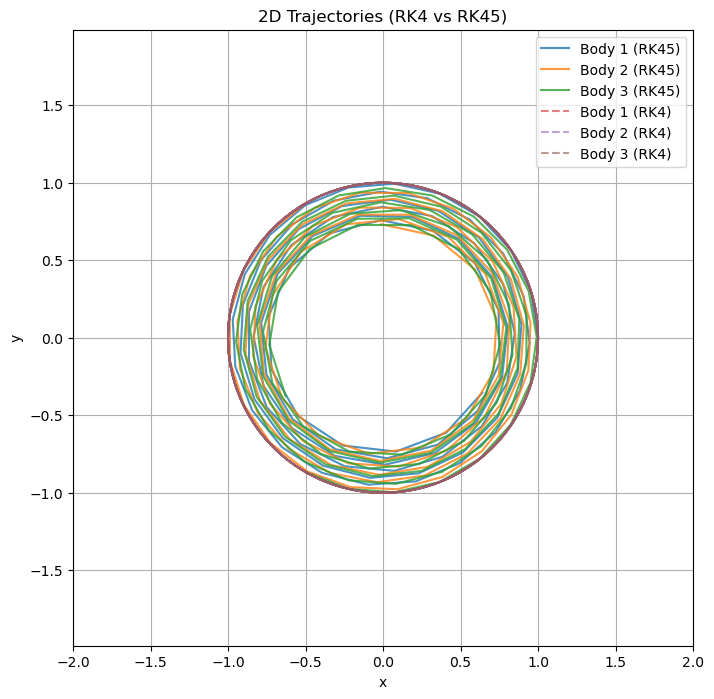

In [5]:
plt.figure(figsize=(8, 8))

# RK45 trajectories
plt.plot(p1x_rk45, p1y_rk45, label='Body 1 (RK45)', alpha=0.8)
plt.plot(p2x_rk45, p2y_rk45, label='Body 2 (RK45)', alpha=0.8)
plt.plot(p3x_rk45, p3y_rk45, label='Body 3 (RK45)', alpha=0.8)

# RK4 trajectories (dashed)
plt.plot(p1x_rk4, p1y_rk4, '--', label='Body 1 (RK4)', alpha=0.6)
plt.plot(p2x_rk4, p2y_rk4, '--', label='Body 2 (RK4)', alpha=0.6)
plt.plot(p3x_rk4, p3y_rk4, '--', label='Body 3 (RK4)', alpha=0.6)

plt.xlabel('x')
plt.ylabel('y')
plt.title('2D Trajectories (RK4 vs RK45)')
plt.legend()
plt.axis('equal')
plt.grid(True)

plt.xlim(-2, 2)
plt.ylim(-2, 2)

plt.show()

### Accuracy test

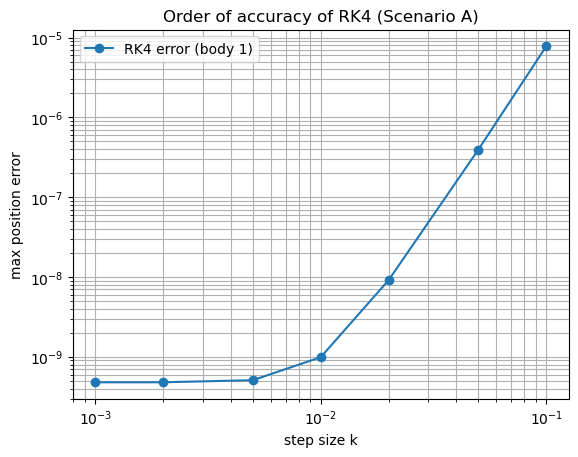

In [6]:
# Scenario A: order-of-accuracy test
t_span_A = (0.0, 10.0)        # you can adjust, but keep it moderate
masses_A = (m1A, m2A, m3A)       # equal masses from Scenario A

k_values = [0.1, 0.05, 0.02, 0.01, 0.005, 0.002, 0.001]

k_array, err_array = rk4_error_vs_k(init_cond_1, t_span_A, masses_A, k_values)

plt.figure()
plt.loglog(k_array, err_array, 'o-', label='RK4 error (body 1)')
plt.xlabel("step size k")
plt.ylabel("max position error")
plt.title("Order of accuracy of RK4 (Scenario A)")
plt.grid(True, which="both")
plt.legend()
plt.show()

## Scenario B

In [7]:
# ===========================
# Scenario B: Unequal masses
# Same equilateral triangle geometry
# ===========================

# Positions (same as scenario A)
init_pos_1B = np.array([ 1.0, 0.0])
init_pos_2B = np.array([-0.5,  np.sqrt(3)/2])
init_pos_3B = np.array([-0.5, -np.sqrt(3)/2])

# Masses (unequal)
m1B, m2B, m3B = 1.0, 2.0, 3.0

# Start from the same rotational velocities as Scenario A
omega = 0.8
v1 = np.array([0.0,         omega])
v2 = np.array([0.7*omega,  -0.35*omega])
v3 = np.array([-0.7*omega, -0.35*omega])

# Adjust velocities so that total momentum = 0 (no drift)
M = m1B + m2B + m3B
v_com = (m1B*v1 + m2B*v2 + m3B*v3) / M

init_vel_1B = v1 - v_com
init_vel_2B = v2 - v_com
init_vel_3B = v3 - v_com

init_cond_2 = np.array([
    init_pos_1B, init_pos_2B, init_pos_3B,
    init_vel_1B, init_vel_2B, init_vel_3B 
]).ravel()
#ravel to make it one dimensional to satisfy solve_ivp conditions
#init_cond needs to be an array as s variable in def system_odes also needs to be an array


## Scenario C

In [8]:
# ===========================
# Scenario C: One massive + two small
# "Scattering / non-orbiting" example
# ===========================

# Masses
m1C = 100.0   # big mass
m2C = 1.0     # small body 1
m3C = 1.0     # small body 2

G = 1.0

# Positions
init_pos_1C = np.array([0.0, 0.0])    # big mass near origin
init_pos_2C = np.array([5.0, 0.0])    # small body 1 to the right
init_pos_3C = np.array([0.0, -6.0])   # small body 2 below

# Velocities (chosen NOT to be circular)
# Just some arbitrary directions and magnitudes
v1 = np.array([0.1, 0.0])            # big mass: very slow
v2 = np.array([-1.5,  1.0])          # small body 1: diagonally inwards
v3 = np.array([ 2.0,  0.5])          # small body 2: diagonally across

# Optional: keep center of mass roughly at rest
M = m1C + m2C + m3C
v_com = (m1C*v1 + m2C*v2 + m3C*v3) / M

init_vel_1C = v1 - v_com
init_vel_2C = v2 - v_com
init_vel_3C = v3 - v_com

init_cond_3 = np.array([
    init_pos_1C, init_pos_2C, init_pos_3C,
    init_vel_1C, init_vel_2C, init_vel_3C 
]).ravel()
#ravel to make it one dimensional to satisfy solve_ivp conditions
#init_cond needs to be an array as s variable in def system_odes also needs to be an array

In [9]:
# ===========================
# Scenario A: Equal masses
# Rotating equilateral triangle
# ===========================

# ===========================
# Scenario B: Unequal masses
# Same equilateral triangle geometry
# ===========================

# ===========================
# Scenario C: One massive + two small
# "Scattering / non-orbiting" example
# ===========================

# Find stability region 

Classical RK4 for $s=p=4$

$$
\begin{align*}
&\phi_1 = F(v_n, u_n) \\

&\phi_2 = F(v_n + \frac{k}{2}\phi_1, t_n + \frac{k}{2}) \\

&\phi_3 = F(v_n + \frac{k}{2}\phi_2, t_n + \frac{k}{2}) \\

&\phi_4 = F(v_n + k\phi_3, t_n + k) \\

&v_{n+1} = v_n + \frac{k}{6}(\phi_1 + 2\phi_2 + 2\phi_3 + \phi_4)
\end{align*}
$$



**Test Equation** $\frac{du}{dt}' = au$ 

for this ODE $f_n = av_n$ 

a multistep formula reduces to $\sum^s_{j=0}(\alpha_j - \tilde{k}\beta_j)v_{n+j}=0  \quad     where \ \tilde{k} = ak$

a multistep formula is absolutely stable for a given $\tilde{k}$ if all roots of $\pi_{\tilde{k}} \  satisfy \ |z| \leq 1$


compute values of $\phi_i$

$$
\begin{align*}
&\phi_1 = av_n \\

&\phi_2 = a(v_n + \frac{k}{2}\phi_1) = a(v_n + \frac{k}{2}(av_n)) = av_n(1 + \frac{\tilde{k}}{2}) \\

&\phi_3 = a(v_n + \frac{k}{2}\phi_2) = av_n(1 + \frac{\tilde{k}}{2} + \frac{\tilde{k}^2}{4}) \\

&\phi_4 = a(v_n + k\phi_3) = av_n(1 + \tilde{k} + \frac{\tilde{k}^2}{2} + \frac{\tilde{k}^3}{4})\\

\end{align*}
$$



$v_{n+1} = v_n +  \frac{k}{6}(\phi_1 + 2\phi_2 + 2\phi_3 + \phi_4)$

$v_{n+1} = v_n (1 + \frac{\tilde{k}}{6}(  1 + 2(1 + \frac{\tilde{k}}{2}) + 2(1 + \frac{\tilde{k}}{2} + \frac{\tilde{k}^2}{4}) + (1 + \tilde{k} + \frac{\tilde{k}^2}{2} + \frac{\tilde{k}^3}{4}) ))$


$v_{n+1} = v_n( 1 + \tilde{k} + \frac{\tilde{k}^2}{2} + \frac{\tilde{k}^3}{6} + \frac{\tilde{k}^4}{24})$

$R(\tilde{k}) = 1 + \tilde{k} + \frac{\tilde{k}^2}{2} + \frac{\tilde{k}^3}{6} + \frac{\tilde{k}^4}{24}$

The absolute stability region is the set 
$S = \{z \in \mathbb{C}: |R(z)| \leq 1\}$

$|1 + \tilde{k} + \frac{\tilde{k}^2}{2} + \frac{\tilde{k}^3}{6} + \frac{\tilde{k}^4}{24}| \leq 1$

restricted to the negative real axis get $k<\frac{2.785}{|\lambda|}$

it is bounded (small, finite region in the left half plane)
RK4 is not A-stable


Local discretization error
$Lu(t_n) = C_0u + C_1ku' + C_k^2u'' + \dots$
local discretization  $error = O(k^4)$

“Diagonalize 
M
\*
M 
\*
 . All eigenvalues 
λ
λ should be such that 
k
λ
kλ is in the stability region.”

3. How this connects to your three-body problem
For your rotating equilateral triangle:
The problem is not stiff → eigenvalues of the Jacobian are not huge.
For reasonable k (say 1e-3, 1e-2) you are well inside the RK4 stability region.
So stability doesn’t really constrain k; accuracy does.
In practice:
You could compute the Jacobian at your initial state, find its eigenvalues 
λ
i
λ 
i
​	
 , and check that 
k
λ
i
kλ 
i
​	
  lies comfortably in the region.
But for this non-stiff configuration, almost any “smallish” k will be stable with RK4/RK45.
You then choose k based on:
how smooth the trajectories look,
how well energy is conserved,
or using an adaptive solver (RK45) and just give it a tolerance.
So in your report, the stability-region part is mainly to say:
“RK4 has a bounded stability region, explicit method, not suitable for stiff problems.”
“For our three-body configurations the Jacobian eigenvalues are moderate, so for the k we use, 
k
λ
kλ lies inside the stability region → no stability issues.”
“Choice of k is then dictated by accuracy (global error 
O
(
k
4
)
O(k 
4
 )), not stability.”


⭐ THE MOST IMPORTANT IDEA
There is NO such thing as a “best k” that can be determined analytically from stability OR accuracy.
What you can do is:
Stability region → tells you which k values are dangerous / forbidden.
Accuracy requirements → tell you how small k must be to reach your desired error.
So:
✔ Stability gives you an upper limit on k
✔ Accuracy gives you a lower limit on k


In [10]:
import numpy as np

# ---- your system_odes here ----
def system_odes(t, s, m1, m2, m3):
    r1, r2, r3 = s[0:2], s[2:4], s[4:6]
    dr1_dt, dr2_dt, dr3_dt = s[6:8], s[8:10], s[10:12]
    v1, v2, v3 = dr1_dt, dr2_dt, dr3_dt

    dv1_dt = m3*(r3 - r1)/np.linalg.norm(r3 - r1)**3 + m2*(r2 - r1)/np.linalg.norm(r2 - r1)**3
    dv2_dt = m3*(r3 - r2)/np.linalg.norm(r3 - r2)**3 + m1*(r1 - r2)/np.linalg.norm(r1 - r2)**3
    dv3_dt = m1*(r1 - r3)/np.linalg.norm(r1 - r3)**3 + m2*(r2 - r3)/np.linalg.norm(r2 - r3)**3
    
    return np.array([
        v1[0], v1[1],
        v2[0], v2[1],
        v3[0], v3[1],
        dv1_dt[0], dv1_dt[1],
        dv2_dt[0], dv2_dt[1],
        dv3_dt[0], dv3_dt[1]
    ])

# ---- initial condition (your code) ----
init_pos_1A = np.array([ 1.0, 0.0])
init_pos_2A = np.array([-0.5,  np.sqrt(3)/2])
init_pos_3A = np.array([-0.5, -np.sqrt(3)/2])

m1A = m2A = m3A = 1.0
G = 1.0
a = np.sqrt(3.0)
omega = np.sqrt(3*G*m1A / a**3)

init_vel_1A = omega * np.array([0.0,         1.0])
init_vel_2A = omega * np.array([-np.sqrt(3)/2, -0.5])
init_vel_3A = omega * np.array([ np.sqrt(3)/2, -0.5])

init_cond_1 = np.array([
    init_pos_1A, init_pos_2A, init_pos_3A,
    init_vel_1A, init_vel_2A, init_vel_3A 
]).ravel()

# ---- wrapper with fixed masses ----
def f(t, s):
    return system_odes(t, s, m1A, m2A, m3A)

# ---- finite-difference Jacobian ----
def jacobian_fd(f, t, u, eps=1e-6):
    u = np.asarray(u, float)
    n = u.size
    f0 = f(t, u)
    J = np.zeros((n, n))
    for j in range(n):
        du = np.zeros(n)
        du[j] = eps
        fp = f(t, u + du)
        fm = f(t, u - du)
        J[:, j] = (fp - fm) / (2*eps)
    return J

# ---- compute Jacobian and eigenvalues at (t=0, init_cond_1) ----
M_star = jacobian_fd(f, 0.0, init_cond_1)
eigvals, eigvecs = np.linalg.eig(M_star)
print("Eigenvalues:", eigvals)


Eigenvalues: [-1.07456993e+00+0.j          1.07456993e+00+0.j
  5.37284966e-01+0.j         -2.83832069e-17+0.75983569j
 -2.83832069e-17-0.75983569j  5.37284966e-01+0.j
 -5.37284966e-01+0.j         -5.37284966e-01+0.j
 -4.30160003e-06+0.j         -4.30159053e-06+0.j
  4.30160003e-06+0.j          4.30159053e-06+0.j        ]


The problem is not stiff: stability does not force a smaller step than accuracy does, so an explicit method like RK4 is perfectly appropriate.

3. Where does the order of accuracy 
O
(
k
4
)
O(k 
4
 ) come in?
Now separate two completely different questions:
Stability: does the numerical solution stay bounded instead of blowing up?
This is what the 
∣
R
(
k
λ
)
∣
≤
1
∣R(kλ)∣≤1 stuff is about.
For your system, stability says 
k
k can be as large as 
∼
2
∼2.
Accuracy: how close is the numerical solution to the true solution?
For RK4, global error over a fixed time interval is 
O
(
k
4
)
O(k 
4
 ).
That means if you halve 
k
k, the error shrinks by a factor of about 
2
4
=
16
2 
4
 =16.
Formally for RK4:
Local truncation error (one step) = 
O
(
k
5
)
O(k 
5
 ),
Global error after 
T
/
k
T/k steps = 
O
(
k
4
)
O(k 
4
 ).
In practice:
Suppose with step 
k
1
=
0.01
k 
1
​	
 =0.01 you get some max error 
E
1
E 
1
​	
  in positions.
If you reduce step to 
k
2
=
0.005
k 
2
​	
 =0.005, you expect approximately
E
2
≈
E
1
(
k
2
k
1
)
4
=
E
1
(
1
2
)
4
=
E
1
16
.
E 
2
​	
 ≈E 
1
​	
 ( 
k 
1
​	
 
k 
2
​	
 
​	
 ) 
4
 =E 
1
​	
 ( 
2
1
​	
 ) 
4
 = 
16
E 
1
​	
 
​	
 .
So how do you choose 
k
k in real life?
Check stability:
From eigenvalues + RK4 region, you know you can go up to roughly 
k
∼
2
k∼2 without blowing up (for the frozen linearization).
So anything like 
k
=
0.1
,
0.01
,
0.001
k=0.1,0.01,0.001 is totally safe from stability POV.
Then choose 
k
k by accuracy, not stability:
You try a step 
k
k (say 0.01), integrate up to some time 
T
T.
Then repeat with 
k
/
2
k/2.
If the solutions are still noticeably different, you reduce 
k
k further.
Because the difference between the 
k
k and 
k
/
2
k/2 solutions behaves like 
O
(
k
4
)
O(k 
4
 ), you can use that to estimate the actual error.
So the logic is:
Use eigenvalues + stability region to show:
“Stability allows huge steps (e.g. 
k
∼
1
k∼1–2). So the system is not stiff.”
Use order of accuracy 
O
(
k
4
)
O(k 
4
 ) to pick a much smaller 
k
k that gives you the precision you want (e.g. 
k
=
0.01
k=0.01, 
0.001
0.001, etc).
In your 3-body problem:
Stability says: 
k
≲
2.6
k≲2.6 (so 
k
=
0.01
k=0.01 is ridiculously safe).
Accuracy for nice orbits usually pushes you down to something like 
k
∼
10
−
2
k∼10 
−2
  or smaller.
That big gap between “stable” 
k
k and “accurate” 
k
k is exactly the signature of a non-stiff problem.